El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Importar bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

import time

## Preprocesamiento de datos y EDA

### Cargar archivo

In [4]:
df = pd.read_csv(r'C:/Users/bokol/OneDrive/Desktop/Courses/car_data.csv')

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
print(f"La cantidad de filas duplicadas es: {df.duplicated().sum()}.")
print(f"El porcentaje de filas duplicadas es: {df.duplicated().sum()/len(df):.2%}.")

La cantidad de filas duplicadas es: 262.
El porcentaje de filas duplicadas es: 0.07%.


In [8]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Descripción del DataFrame

Cada observación del conjunto de datos contiene información sobre vehículos específicos. La información proporcionada es la siguiente:

#### **Características:**

<code style="background:grey;color:black">DateCrawled</code> : fecha en la que se descargó el perfil de la base de datos
<br>
<code style="background:grey;color:black">VehicleType</code> : tipo de carrocería del vehículo
<br>
<code style="background:grey;color:black">RegistrationYear</code> : año de matriculación del vehículo
<br>
<code style="background:grey;color:black">Gearbox</code> : tipo de caja de cambios
<br>
<code style="background:grey;color:black">Power</code> : potencia (CV)
<br>
<code style="background:grey;color:black">Model</code> : modelo del vehículo
<br>
<code style="background:grey;color:black">Mileage</code> : kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
<br>
<code style="background:grey;color:black">RegistrationMonth</code> : mes de matriculación del vehículo
<br>
<code style="background:grey;color:black">FuelType</code> : tipo de combustible
<br>
<code style="background:grey;color:black">Brand</code> : marca del vehículo
<br>
<code style="background:grey;color:black">NotRepaired</code> : vehículo con o sin reparación
<br>
<code style="background:grey;color:black">DateCreated</code> : fecha de creación del perfil
<br>
<code style="background:grey;color:black">NumberOfPictures</code> : número de fotos del vehículo
<br>
<code style="background:grey;color:black">PostalCode</code> : código postal del propietario del perfil (usuario)
<br>
<code style="background:grey;color:black">LastSeen</code> : fecha de la última vez que el usuario estuvo activo

#### **Objetivo**

<br>
<code style="background:grey;color:black">Price</code> : precio (en euros)


Hay un total de **354.369 observaciones** y un total de **16 columnas**.

### Observaciones

Hay algunos problemas en el DataFrame que deben abordarse antes de continuar:

- Nombres de columnas: Se cambiarán los nombres de columnas que no sigan las mejores prácticas.
- Valores faltantes: En las columnas <code style="background:grey;color:black">VehicleType</code>, <code style="background:grey;color:black">Gearbox</code>, <code style="background:grey;color:black">Model</code>, <code style="background:grey;color:black">FuelType</code> y <code style="background:grey;color:black">NotRepaired</code> hay valores faltantes que se eliminarán, ya que no proporcionan los detalles que necesitamos para construir sobre los modelos.
- Filas duplicadas: El conjunto de datos contiene **262 filas duplicadas**, estas también se eliminarán ya que no proporcionan ningún beneficio para nuestros modelos.
- Columnas a eliminar: Las columnas <code style="background:grey;color:black">DateCrawled</code>, <code style="background:grey;color:black">DateCreated</code>,<code style="background:grey;color:black">NumberOfPictures</code>,<code style="background:grey;color:black">PostalCode</code>,<code style="background:grey;color:black">LastSeen</code>, contienen información irrelevante para el precio se eliminarán del conjunto de datos.
- Datos categóricos a datos numéricos: Por último, las columnas que contienen datos categóricos se cambiarán a datos numéricos.

#### Corrección de problemas encontrados

En la siguiente parte corregiré los problemas encontrados en los Datos.

In [9]:
# Eliminar duplicados 
df.drop_duplicates(inplace=True)

In [10]:
# Eliminar filas con valores faltantes
df.dropna(inplace=True)

In [11]:
# Eliminar columnas con información irrelevante
not_used = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
df = df.drop(not_used, axis=1)

In [12]:
# Cambiar los nombres de las columnas
df.rename(columns={'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand', 'NotRepaired': 'not_repaired'}, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245567 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               245567 non-null  int64 
 1   vehicle_type        245567 non-null  object
 2   registration_year   245567 non-null  int64 
 3   gearbox             245567 non-null  object
 4   power               245567 non-null  int64 
 5   model               245567 non-null  object
 6   mileage             245567 non-null  int64 
 7   registration_month  245567 non-null  int64 
 8   fuel_type           245567 non-null  object
 9   brand               245567 non-null  object
 10  not_repaired        245567 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.5+ MB


Los datos ahora son uniformes, ya no hay valores NaN y todos los puntos de datos son numéricos. A continuación, prepararé los datos antes de comenzar a modelar.
Hay un total de **245.567 observaciones** y un total de **11 columnas**.

### Transformación de características categóricas en numéricas

In [14]:
ordinal_encoder = OrdinalEncoder()

In [15]:
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [16]:
df[cat_columns] = ordinal_encoder.fit_transform(df[cat_columns])

In [17]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,37.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0
6,2200,1.0,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0
7,0,4.0,1980,1.0,50,166.0,40000,7,6.0,37.0,0.0


### Separación de características y objetivo.

In [18]:
X = df.drop(['price'], axis=1)
y = df['price']

### Creacion de datasets para entrenamiento y prueba.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=12345)

### Escaladar datos

In [21]:
Standard_scaler = StandardScaler()
X_train = Standard_scaler.fit_transform(X_train)
X_valid = Standard_scaler.transform(X_valid)
X_test = Standard_scaler.transform(X_test)

Ahora estamos listos para entrenar a nuestros modelos.

## Entrenamiento del modelo 

En esta sección entrenaremos diferentes modelos y ajustaremos algunos hiperparámetros, si es posible, por supuesto. Usaremos los siguientes algoritmos:

- LinearRegression
- RandomForestRegressor (con diferentes n_estimators y max_depth)
- LightBGMRegressor (con diferentes n_estimators y max_depth)
- XGBoostRegressor (con diferentes n_estimators y max_depth)
- CatBoostRegressor (con diferente número de iteraciones y profundidad)

### LinearRegression

In [22]:
#Modelo de regresión lineal, entrenamiento y predicción de resultados.
lr_model = LinearRegression()
start = time.time()
lr_model.fit(X_train, y_train)
end = time.time()
fit_time_LR = end - start

#Predecir el objetivo y calcular el RMSE y verificar el tiempo para la predicción
start = time.time()
y_pred = lr_model.predict(X_test)
lr_model.fit(X_train, y_train)
end = time.time()
pred_time_LR = end - start

rmse_score_lr = mean_squared_error(y_test, y_pred)**0.5

#Hallazgos
print(f'La puntuación RMSE del modelo de regresión lineal es {rmse_score_lr}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_time_LR}.')
print(f'Tiempo necesario para predecir el objetivo: {pred_time_LR}.')

La puntuación RMSE del modelo de regresión lineal es 3345.569342736898.
Tiempo necesario para entrenar el modelo: 0.13796329498291016.
Tiempo necesario para predecir el objetivo: 0.04841780662536621.


### RandomForestRegressor

#### RandomForestRegressor no ajustado

In [24]:
rf_base_model = RandomForestRegressor()

#Modelo de Random Forest, entrenamiento y predicción de resultados.
start = time.time()
rf_base_model.fit(X_train, y_train)
end = time.time()
fit_base_time_RF = end - start

#Predecir el objetivo y calcular el RMSE y verificar el tiempo para la predicción
start = time.time()
y_pred = rf_base_model.predict(X_valid)
end = time.time()
predict_base_time_RF = end - start

rmse_base_score_rf = mean_squared_error(y_valid, y_pred) ** 0.5

#Hallazgos
print(f'La puntuación RMSE del modelo Random Forest no ajustado es {rmse_base_score_rf}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_base_time_RF}.')
print(f'Tiempo necesario para predecir el objetivo: {predict_base_time_RF}.')

La puntuación RMSE del modelo Random Forest no ajustado es 1697.4703851476386.
Tiempo necesario para entrenar el modelo: 49.08885431289673.
Tiempo necesario para predecir el objetivo: 1.6319105625152588.


#### RandomForestRegressor ajustado

In [25]:
# Encuentra los parámetros óptimos para el modelo
# Definir cuadrícula de parámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth' : [None, 10, 20],
}

# Inicializar GridSearchCV
clf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit model
clf.fit(X_train, y_train)

# Mejores parámetros y puntuación
print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 20, 'n_estimators': 200}
Best score: 0.873105580434466


In [26]:
best_rf_model = RandomForestRegressor(n_estimators = 200, max_depth=20, n_jobs=-1, random_state=234)
start = time.time()
best_rf_model.fit(X_train, y_train)
end = time.time()
fit_time_RF = end - start

#Ahora verifiquemos cuánto tiempo se requiere para la predicción y calculemos el RMSE.
start = time.time()
y_pred = best_rf_model.predict(X_test)
end = time.time()
pred_time_RF = end - start

rmse_score_rf = mean_squared_error(y_test, y_pred)**0.5

print(f'La puntuación RMSE del modelo Random Forest ajustado es {rmse_score_rf}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_time_RF}.')
print(f'Tiempo necesario para predecir el objetivo: {pred_time_RF}.')

La puntuación RMSE del modelo Random Forest ajustado es 1659.1020292212595.
Tiempo necesario para entrenar el modelo: 17.910974740982056.
Tiempo necesario para predecir el objetivo: 0.6515119075775146.


### LightBGMRegressor

#### LightBGMRegressor no ajustado

In [27]:
lg_base_model = LGBMRegressor()

start = time.time()
lg_base_model.fit(X_train, y_train)
end = time.time()
fit_base_time_lg = end - start

start = time.time()
y_pred = lg_base_model.predict(X_valid)
end = time.time()
predict_base_time_lg = end - start

rmse_base_score_lg = mean_squared_error(y_valid, y_pred) ** 0.5

#Scores
print(f'La puntuación RMSE del LightBGMRegressor no ajustado es {rmse_base_score_lg}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_base_time_lg}.')
print(f'Tiempo necesario para predecir el objetivo: {predict_base_time_lg}.')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 157162, number of used features: 10
[LightGBM] [Info] Start training from score 5123.989584
La puntuación RMSE del LightBGMRegressor no ajustado es 1774.6078056056222.
Tiempo necesario para entrenar el modelo: 0.7433686256408691.
Tiempo necesario para predecir el objetivo: 0.03466153144836426.


#### LightBGMRegressor ajustado

In [28]:
# Encuentra los parámetros óptimos para el modelo
# Definir cuadrícula de parámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth' : [None, 10, 20],
}

# Inicializar GridSearchCV
clf = GridSearchCV(LGBMRegressor(random_state=42), param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit model
clf.fit(X_train, y_train)

#Mejores parámetros y puntuación
print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 157162, number of used features: 10
[LightGBM] [Info] Start training from score 5123.989584
Best parameters: {'max_depth': None, 'n_estimators': 200}
Best score: 0.8719323962767491


In [29]:
best_lg_model = LGBMRegressor(n_estimators=200, max_depth=None, random_state=234)
start = time.time()
best_lg_model.fit(X_train, y_train)
end = time.time()
fit_time_LG = end - start

# predecir el objetivo y verificar la puntuación RMSE y el tiempo que requiere la predicción
start = time.time()
y_pred = best_lg_model.predict(X_test)
end = time.time()
pred_time_LG = end - start

rmse_score_lg = mean_squared_error(y_test, y_pred)**0.5

print(f'La puntuación RMSE del LightBGMRegressor ajustado es {rmse_score_lg}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_time_LG}.')
print(f'Tiempo necesario para predecir el objetivo: {pred_time_LG}.')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 157162, number of used features: 10
[LightGBM] [Info] Start training from score 5123.989584
La puntuación RMSE del LightBGMRegressor ajustado es 1679.4008178518582.
Tiempo necesario para entrenar el modelo: 0.5114762783050537.
Tiempo necesario para predecir el objetivo: 0.08324241638183594.


### XGBoostRegressor 

#### XGBoostRegressor no ajustado

In [30]:
xgb_base_model = xgb.XGBRegressor(n_jobs=-1)

start = time.time()
xgb_base_model.fit(X_train, y_train)
end = time.time()
fit_base_time_xgb = end - start

start = time.time()
y_pred = xgb_base_model.predict(X_valid)
end = time.time()
predict_base_time_xgb = end - start

rmse_base_score_xgb = mean_squared_error(y_valid, y_pred) ** 0.5

print(f'La puntuación RMSE del XGBoostRegressor no ajustado es {rmse_base_score_xgb}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_base_time_xgb}.')
print(f'Tiempo necesario para predecir el objetivo: {predict_base_time_xgb}.')

La puntuación RMSE del XGBoostRegressor no ajustado es 1712.3764373444214.
Tiempo necesario para entrenar el modelo: 0.4512345790863037.
Tiempo necesario para predecir el objetivo: 0.0283200740814209.


#### XGBoostRegressor ajustado

In [31]:
# Encuentra los parámetros óptimos para el modelo
# Definir cuadrícula de parámetros
param_grid = {
    'n_estimators': [100, 150],
    'max_depth' : [10, 20],
}

# Inicializar GridSearchCV
clf = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit model
clf.fit(X_train, y_train)

# Mejores parámetros y puntuación
print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'max_depth': 10, 'n_estimators': 100}
Best score: 0.8765224916097425


In [32]:
best_xgb_model = xgb.XGBRegressor(random_state=12345, n_estimators=100, max_depth=10, n_jobs=-1)
start = time.time()
best_xgb_model.fit(X_train,y_train)
end = time.time()
fit_time_XG = end - start

#predecir el objetivo y verificar la puntuación RMSE y el tiempo que requiere la predicción
start = time.time()
y_pred = best_xgb_model.predict(X_test)
end = time.time()
pred_time_XG = end - start

rmse_score_xg = mean_squared_error(y_test, y_pred)**0.5

print(f'La puntuación RMSE del XGBoostRegressor ajustado es {rmse_score_xg}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_time_XG}.')
print(f'Tiempo necesario para predecir el objetivo: {pred_time_XG}.')

La puntuación RMSE del XGBoostRegressor ajustado es 1643.957325620187.
Tiempo necesario para entrenar el modelo: 0.823265552520752.
Tiempo necesario para predecir el objetivo: 0.04970979690551758.


### CatBoostRegressor

In [33]:
cb_base_model = CatBoostRegressor(verbose=0)

start = time.time()
cb_base_model.fit(X_train, y_train)
end = time.time()
fit_base_time_CB = end - start

start = time.time()
y_pred = cb_base_model.predict(X_valid)
end = time.time()
predict_base_time_CB = end - start

rmse_base_score_cb = mean_squared_error(y_valid, y_pred) ** 0.5

print(f'La puntuación RMSE del CatBoostRegressor no ajustado es {rmse_base_score_cb}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_base_time_CB}.')
print(f'Tiempo necesario para predecir el objetivo: {predict_base_time_CB}.')

La puntuación RMSE del CatBoostRegressor no ajustado es 1686.4369413012334.
Tiempo necesario para entrenar el modelo: 13.089129209518433.
Tiempo necesario para predecir el objetivo: 0.014100313186645508.


#### CatBoostRegressor ajustado

In [34]:
# Encuentra los parámetros óptimos para el modelo
# Definir cuadrícula de parámetros
param_grid = {
    'iterations': [100, 200, 500],
    'depth' : [5, 10, 15],
}

# Inicializar GridSearchCV
clf = GridSearchCV(CatBoostRegressor(random_state=12345), param_grid, verbose=0)

# Fit model
clf.fit(X_train, y_train)

# Mejores parámetros y puntuación
print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')

Learning rate set to 0.5
0:	learn: 3353.5202607	total: 8.42ms	remaining: 834ms
1:	learn: 2727.3437948	total: 16.6ms	remaining: 813ms
2:	learn: 2487.8739485	total: 24.2ms	remaining: 784ms
3:	learn: 2332.8577616	total: 31.8ms	remaining: 763ms
4:	learn: 2256.2291809	total: 39.3ms	remaining: 746ms
5:	learn: 2186.9423814	total: 48.2ms	remaining: 755ms
6:	learn: 2144.9065171	total: 55.9ms	remaining: 743ms
7:	learn: 2110.1257265	total: 64.2ms	remaining: 738ms
8:	learn: 2089.4685338	total: 71.6ms	remaining: 724ms
9:	learn: 2057.5430763	total: 79.8ms	remaining: 719ms
10:	learn: 2040.8852545	total: 87.7ms	remaining: 709ms
11:	learn: 2024.3194910	total: 95.5ms	remaining: 701ms
12:	learn: 2006.0570309	total: 103ms	remaining: 691ms
13:	learn: 1990.6528557	total: 111ms	remaining: 681ms
14:	learn: 1979.3559096	total: 119ms	remaining: 672ms
15:	learn: 1957.9519393	total: 128ms	remaining: 669ms
16:	learn: 1944.6970851	total: 137ms	remaining: 670ms
17:	learn: 1937.2508454	total: 148ms	remaining: 674ms
1

In [40]:
best_cb_model = CatBoostRegressor(random_state=12345, iterations=500, 
                                       depth=10, verbose=0)
start = time.time()
best_cb_model.fit(X_train, y_train)
end = time.time()
fit_time_CB = end - start

#Predecir el objetivo y comprobar la puntuación RMSE y el tiempo
start = time.time()
y_pred = best_cb_model.predict(X_test)
end = time.time()
pred_time_CB = end - start

rmse_score_cb = mean_squared_error(y_test, y_pred)**0.5

print(f'La puntuación RMSE del CatBoostRegressor ajustado es {rmse_score_cb}.')
print(f'Tiempo necesario para entrenar el modelo: {fit_time_CB}.')
print(f'Tiempo necesario para predecir el objetivo: {pred_time_CB}.')

La puntuación RMSE del CatBoostRegressor ajustado es 1604.470861468001.
Tiempo necesario para entrenar el modelo: 15.170401811599731.
Tiempo necesario para predecir el objetivo: 0.0327610969543457.


## Análisis del modelo

A continuación, compararé la puntuación RMSE y el tiempo necesario para obtener una puntuación óptima con los modelos anteriores.

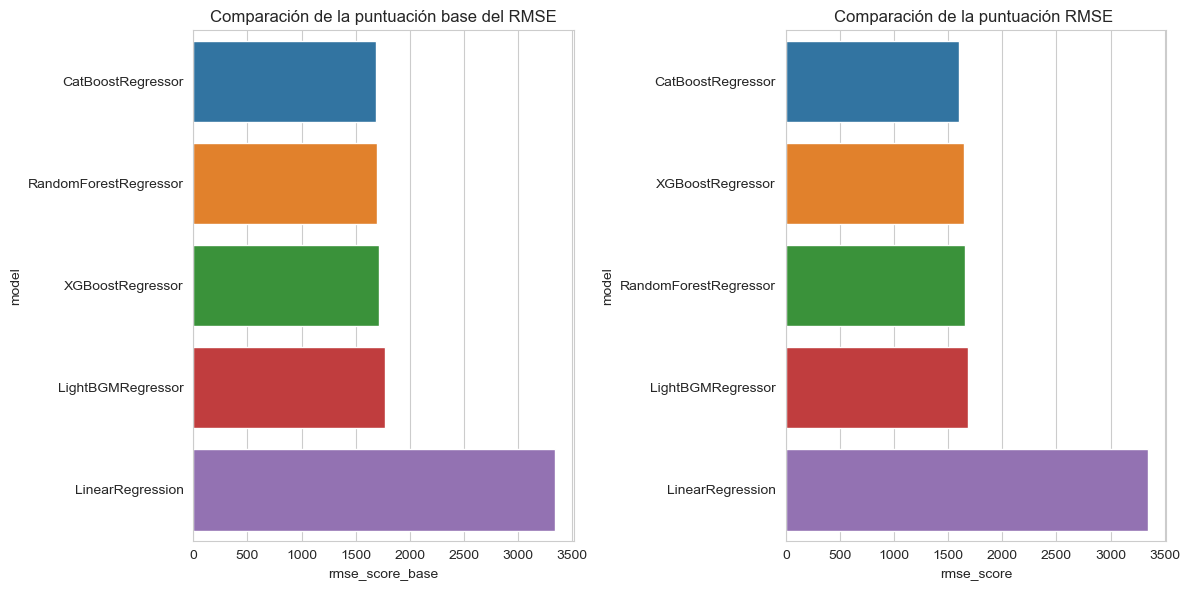

In [50]:
# Rendimiento de los mejores modelos
models = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightBGMRegressor', 'XGBoostRegressor',]
rmse_score = [rmse_score_lr, rmse_score_rf, rmse_score_cb, rmse_score_lg, rmse_score_xg]
rmse_score_base = [rmse_score_lr, rmse_base_score_rf, rmse_base_score_cb, rmse_base_score_lg, rmse_base_score_xgb]
fit_time = [fit_time_LR, fit_time_RF, fit_time_CB, fit_time_LG, fit_time_XG,]
fit_time_base = [fit_time_LR, fit_base_time_RF, fit_base_time_CB, fit_base_time_lg, fit_base_time_xgb]
pred_time = [pred_time_LR, pred_time_RF, pred_time_CB, pred_time_LG, pred_time_XG,]
pred_time_base = [pred_time_LR, predict_base_time_RF, predict_base_time_CB, predict_base_time_lg, predict_base_time_xgb]

# crear un marco de datos
df_comparison = pd.DataFrame(
    data=zip(models, rmse_score, fit_time, pred_time, rmse_score_base, fit_time_base, pred_time_base),
    columns=["model", "rmse_score", "fit_time", "pred_time", "rmse_score_base", "fit_time_base", "pred_time_base"],
).sort_values("rmse_score")

# Métricas de rendimiento de la trama
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("whitegrid")


sns.barplot(
    data=df_comparison.sort_values("rmse_score_base"),
    y="model",
    x="rmse_score_base",
    orient="h",
    ax=ax[0],
)
ax[0].set_title("Comparación de la puntuación base del RMSE")

sns.barplot(
    data=df_comparison.sort_values("rmse_score"),
    y="model",
    x="rmse_score",
    orient="h",
    ax=ax[1],
)
ax[1].set_title("Comparación de la puntuación RMSE ")


plt.tight_layout()
plt.show()

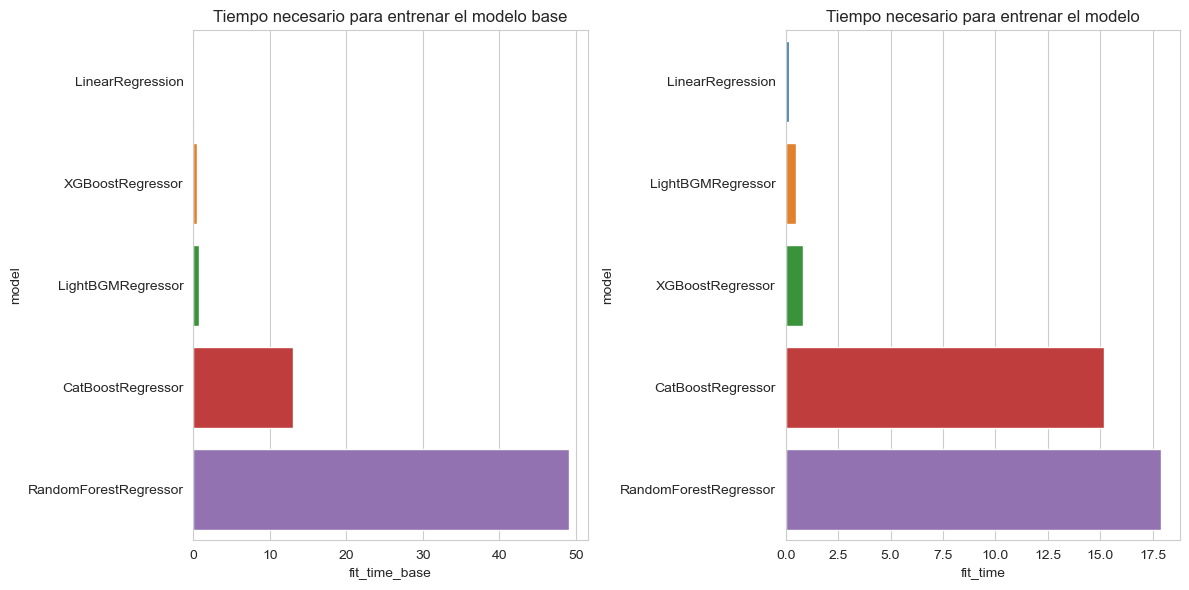

In [51]:
# Métricas de rendimiento de la trama
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=df_comparison.sort_values("fit_time_base"),
    y="model",
    x="fit_time_base",
    orient="h",
    ax=ax[0],
)
ax[0].set_title("Tiempo necesario para entrenar el modelo base")

sns.barplot(
    data=df_comparison.sort_values("fit_time"),
    y="model",
    x="fit_time",
    orient="h",
    ax=ax[1],
)
ax[1].set_title("Tiempo necesario para entrenar el modelo")


plt.tight_layout()
plt.show()

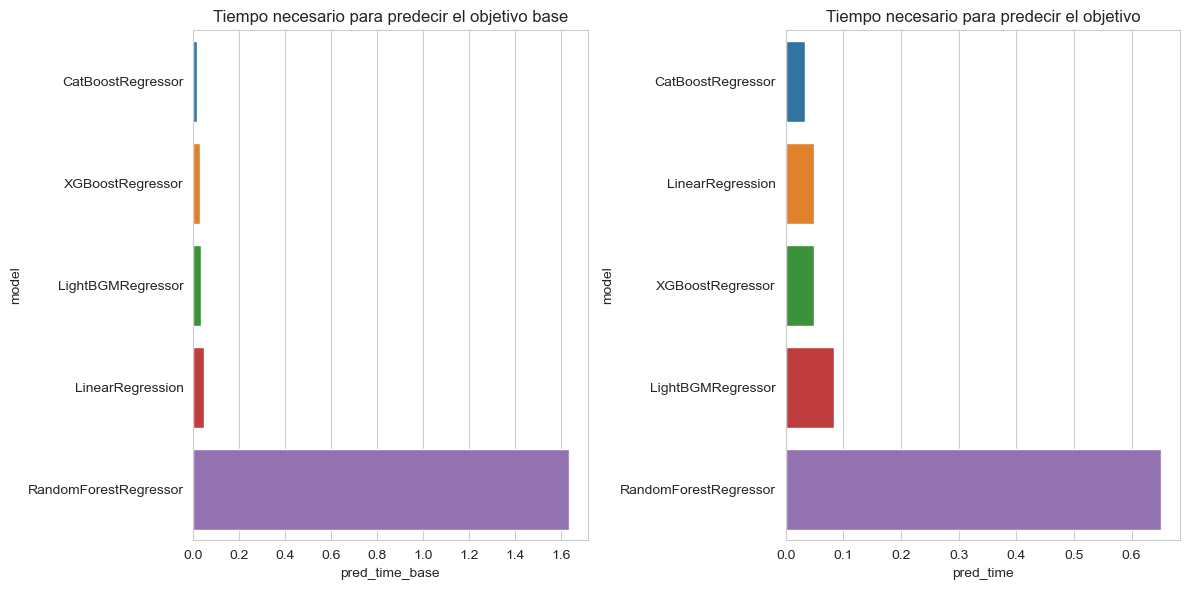

In [52]:
# Métricas de rendimiento de la trama
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=df_comparison.sort_values("pred_time_base"),
    y="model",
    x="pred_time_base",
    orient="h",
    ax=ax[0],
)
ax[0].set_title("Tiempo necesario para predecir el objetivo base")

sns.barplot(
    data=df_comparison.sort_values("pred_time"),
    y="model",
    x="pred_time",
    orient="h",
    ax=ax[1],
)
ax[1].set_title("Tiempo necesario para predecir el objetivo")


plt.tight_layout()
plt.show()

In [53]:
df_comparison.style

,model,rmse_score,fit_time,pred_time,rmse_score_base,fit_time_base,pred_time_base
2,CatBoostRegressor,1604.470861,15.170402,0.032761,1686.436941,13.089129,0.014100
4,XGBoostRegressor,1643.957326,0.823266,0.049710,1712.376437,0.451235,0.028320
1,RandomForestRegressor,1659.102029,17.910975,0.651512,1697.470385,49.088854,1.631911
3,LightBGMRegressor,1679.400818,0.511476,0.083242,1774.607806,0.743369,0.034662
0,LinearRegression,3345.569343,0.137963,0.048418,3345.569343,0.137963,0.048418


### Observations

#### RMSE Score:
1. **CatBoostRegressor**: El modelo CatBoostRegressor tuvo el mejor desempeño y logró un puntaje RMSE de **USD 1686** sin ajuste y un puntaje RMSE de **USD 1604** después del ajuste.

2. **XGBoostRegressor**: El modelo XGBoostRegressor tuvo el segundo mejor desempeño y logró una puntuación de **USD 1712** antes del ajuste y **USD 1643** después del ajuste.

3. **RandomForestRegressor**: El modelo RandomForestRegressor obtuvo el tercer mejor desempeño con un puntaje RMSE de **USD 1697** cuando no estaba ajustado y de **USD 1659** cuando estaba ajustado.

4. **LightBGMRegressor**: En cuarto lugar quedó el modelo LightBGMRegressor, que logró una puntuación RMSE de **USD 1774** sin ajuste, mientras que alcanzó una puntuación RMSE de **USD 1679** cuando se ajustó.

5. **LinearRegression**: Por último, el modelo que presenta el peor desempeño es el modelo de regresión lineal. El modelo de regresión lineal obtuvo una puntuación RMSE de **USD 3345**.

Lo que todos los modelos tienen en común es que funcionan mejor después del ajuste que antes del mismo.

#### Tiempo para entrenar:
1. **LinearRegression**: El modelo de regresión lineal fue el que tardó menos tiempo en entrenarse. Solo necesitó **0.13 segundos**, sin embargo, también es el más simple de los modelos.
2. **LightBGMRegressor**: Este fue el segundo modelo más rápido de entrenar. El modelo base tardó **0.7 segundos** en entrenarse, mientras que el modelo ajustado tardó **0.5 segundos** en entrenarse.
3. **XGBoostRegressor**: El XGBoostRegressor fue el tercer modelo más rápido en entrenarse. El modelo base tardó **0,4 segundos** en entrenarse, mientras que el modelo ajustado tardó el doble, **0,8 segundos**.
4. **CatBoostRegressor**: El modelo CatBoostRegressor fue el penúltimo modelo más rápido. Se necesitaron **13,0 segundos** para entrenar el modelo no ajustado y **15,1 segundos** para entrenar el modelo ajustado.
5. **RandomForestRegressor**: El modelo RandomForestRegressor fue, con diferencia, el más lento de entrenar. En el modelo ajustado, tardó **17.9 segundos**, mientras que el modelo no ajustado tardó nada menos que **49.0 segundos** en entrenarse.

#### Tiempo para predecir:
1. **CatBoostRegressor**: El modelo que tardó menos tiempo en predecir fue el modelo CatBoostRegressor. El modelo no ajustado tardó **0.01 segundos** en predecir y el ajustado **0.03 segundos**
2. **LinearRegression**: El segundo modelo más rápido fue el modelo de regresión lineal. Tanto el modelo ajustado como el no ajustado tardaron **0.04 segundos** en realizar la predicción.
3. **XGBoostRegressor**: El tercer modelo más rápido fue el modelo XGBoostRegressor. El tiempo de predicción para el modelo no ajustado fue de **0.45 segundos** y ligeramente más lento para el modelo ajustado de **0.82 segundos**.
4. **LightBGMRegressor**: El segundo modelo más lento fue el modelo LightBGMRegressor. Necesitó **0.74 segundos** para realizar la predicción en el modelo no ajustado, mientras que el modelo ajustado necesitó **0.51 segundos**.
5. **RandomForestRegressor**: El modelo más lento, una vez más, fue el modelo RandomForestRegressor. Para predecir, el modelo no ajustado tardó **1.63 segundos** y **0.65 segundos** para predecir con el modelo ajustado.

### Conclusión:

Creo que los tiempos de predicción deberían tener un peso mayor que el tiempo que lleva entrenar un modelo, al elegir qué modelo implementar. El modelo deberá entrenarse una vez y luego implementarse posteriormente. Si bien un cliente usará con frecuencia el modelo para predecir y evitar tiempos de procesamiento prolongados para los usuarios, el tiempo de predicción del modelo debe ser lo más bajo posible. Además, y por razones obvias, el puntaje RMSE del modelo debe considerarse crucial.

Por lo tanto, mi recomendación para Rusty Bargain es implementar el modelo CatBoostRegressor. Este modelo logró el puntaje RMSE más prometedor en **USD 1604.47** y el mejor tiempo de predicción **0.032 segundos** de todos los modelos. Además, funcionó relativamente bien en lo que respecta al tiempo de entrenamiento **15.17 segundos**.

Antes de implementar el modelo, se debe considerar ajustarlo aún más. He ajustado el modelo considerando iteraciones y profundidad, pero existe la posibilidad de reducir aún más el puntaje RMSE considerando más parámetros.

# Lista de control

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos